# Glandu segmentācijas datu sagatavošana U-Net un FPN (segmentation_models_pytorch)

Šajā notebook'ā mēs:

- apskatīsim datu struktūru glandu segmentācijas datu kopai,
- nolasīsim anotāciju JSON datnes un pārvērtīsim tās par bināru masku,
- izveidosim `torch.utils.data.Dataset` klasi,
- vizualizēsim dažus piemērus (attēls + maskas pārklājums),
- sagatavosim visu tā, lai nākamajos piezīmjdatoros varētu:
  - trenēt U-Net un FPN modeļus,
  - salīdzināt to rezultātus.

No sākuma datu struktūra ir šāda:

``` bash
data/
  training/
    img/*.bmp
    ann/*.bmp.json
  test/
    img/*.bmp
    ann/*.bmp.json
```

In [1]:
# Importējam nepieciešamas bibliotēkas
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import base64
import json
import zlib
from io import BytesIO

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

In [2]:
# Saknes ceļš uz glandu datu kopu (pielāgo, ja vajag)
GLAND_ROOT = Path("data")

TRAIN_DIR = GLAND_ROOT / "training"
TEST_DIR = GLAND_ROOT / "test"

print("Treniņa mape:", TRAIN_DIR)
print("Testa mape:", TEST_DIR)

Treniņa mape: data/training
Testa mape: data/test


In [3]:
# Atradīsim kādu vienu anotācijas datni, lai apskatītos struktūru
sample_ann_files = list((TRAIN_DIR / "ann").glob("*.bmp.json"))
len(sample_ann_files), sample_ann_files[:3]

(85,
 [PosixPath('data/training/ann/train_77.bmp.json'),
  PosixPath('data/training/ann/train_76.bmp.json'),
  PosixPath('data/training/ann/train_49.bmp.json')])

In [4]:
# Apskatām pirmo anotāciju (strukturāli)
sample_ann_path = sample_ann_files[10]
print("Parauga anotācijas datne:", sample_ann_path)

with open(sample_ann_path, "r", encoding="utf-8") as f:
    sample_ann = json.load(f)

sample_ann.keys(), sample_ann.get("size"), len(sample_ann.get("objects", []))

Parauga anotācijas datne: data/training/ann/train_60.bmp.json


(dict_keys(['description', 'tags', 'size', 'objects']),
 {'height': 522, 'width': 775},
 9)

In [5]:
# Apskatām pirmo objektu paraugā
first_obj = sample_ann["objects"][0]
first_obj

{'id': 61441379,
 'classId': 6467949,
 'description': '',
 'geometryType': 'bitmap',
 'labelerLogin': 'inbox@datasetninja.com',
 'createdAt': '2023-10-03T12:16:14.689Z',
 'updatedAt': '2023-10-03T12:16:14.689Z',
 'tags': [],
 'classTitle': 'gland',
 'bitmap': {'data': 'eJwBoAFf/olQTkcNChoKAAAADUlIRFIAAAD3AAAAZwEDAAAA5iRGUwAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAAFISURBVHicpdXNrcMgEARgrBw4pgRKSWlxaZRCCRw5WObp2YD52fFYgesXscMuxCrKy6u0gO/EoyXuiW/EI/OVuCXuiPtJD8S3Sd+Jx1lfJ90R98QD8Z14ZL5Oup1098S/xD/YjwYb7McNW7CfDX4Tf+ENnt2wL3RLApw3DJ/g4ROFAZJ/kKcnaohr5OkJwwPkP2EYUJGAZ4NxB88G4xGmBsIOBhIgOwqQPwKoQ9lRQPqVUiRgahAcgcsbGNlzg1DC4mCGl8sFQnG5RZfLR6z8TVwssKn7ArVLQ9jV/QaNCwkbFwq0boiPQ2p9vAWtjwU6Hwp0PtyC3vsCvfcbDN7tMLom/iLeTknwpouS12f4yTXxKsAmeVVA9quHQXRNfCF+BfCylwBOdk28BLCylwAr8DxkwPkpiu2vfgCO/7/MzfFLRHfjy1H+DzUnTuYrjOyhAAAAAElFTkSuQmCC4tm2iQ==',
  'origin': [0, 0]}}

In [6]:
# Apskatām, kādas classTitle klases parādās datu kopā (pirmajiem N failiem)
unique_classes = set()

for ann_path in sample_ann_files[:50]:  # var palielināt, ja gribas pilnīgāk
    with open(ann_path, "r", encoding="utf-8") as f:
        ann = json.load(f)
    for obj in ann.get("objects", []):
        unique_classes.add(obj.get("classTitle", "UNKNOWN"))

unique_classes

{'gland'}

In [7]:
def create_binary_mask_from_json(json_path: Path) -> np.ndarray:
    """
    No Supervisely bitmap anotācijas izveido bināru masku.
    Rezultāts: maska (H, W), kur 1 = glands, 0 = fons.

    JSON struktūra (kā tavā train_60.bmp.json):
      "objects": [
        {
          "geometryType": "bitmap",
          "bitmap": {
            "data": <base64(zlib(PNG))>,
            "origin": [x, y]
          },
          ...
        },
        ...
      ]
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    h = data["size"]["height"]
    w = data["size"]["width"]

    mask = np.zeros((h, w), dtype=np.uint8)

    for obj in data.get("objects", []):
        if obj.get("geometryType") != "bitmap":
            # Šajā kopā visi gland objekti ir bitmap, pārējos var ignorēt
            continue

        bm = obj.get("bitmap")
        if not bm:
            continue

        data_b64 = bm.get("data")
        origin = bm.get("origin", [0, 0])
        if not data_b64:
            continue

        x0, y0 = origin

        # 1) base64 -> bytes (zlib stream)
        compressed = base64.b64decode(data_b64)

        # 2) zlib decompress -> PNG bytes
        png_bytes = zlib.decompress(compressed)

        # 3) PNG -> masīvs
        img = Image.open(BytesIO(png_bytes))
        arr = np.array(img)

        # ja ir vairāk kanālu, ņemam pirmo
        if arr.ndim == 3:
            arr = arr[..., 0]

        bmp_mask = (arr > 0).astype(np.uint8)
        h_mask, w_mask = bmp_mask.shape

        # robežu nogriešana, ja nu kas iziet ārpus attēla
        x1 = min(w, x0 + w_mask)
        y1 = min(h, y0 + h_mask)

        mw = x1 - x0
        mh = y1 - y0
        if mw <= 0 or mh <= 0:
            continue

        # 4) ieliekam bitmap masku lielajā maskā (max, ja pārklājas)
        mask[y0:y1, x0:x1] = np.maximum(
            mask[y0:y1, x0:x1],
            bmp_mask[0:mh, 0:mw],
        )

    return mask

In [8]:
# Izvēlamies vienu attēlu+anotāciju no training
img_name = sample_ann_path.stem        # "12345.bmp"
sample_img_path = TRAIN_DIR / "img" / img_name
print("Parauga attēls:", sample_img_path)

img = Image.open(sample_img_path).convert("RGB")
mask = create_binary_mask_from_json(sample_ann_path)

img_np = np.array(img)
print("Attēla forma:", img_np.shape)
print("Maskas forma:", mask.shape, "unikālās vērtības:", np.unique(mask))

Parauga attēls: data/training/img/train_60.bmp
Attēla forma: (522, 775, 3)
Maskas forma: (522, 775) unikālās vērtības: [0 1]


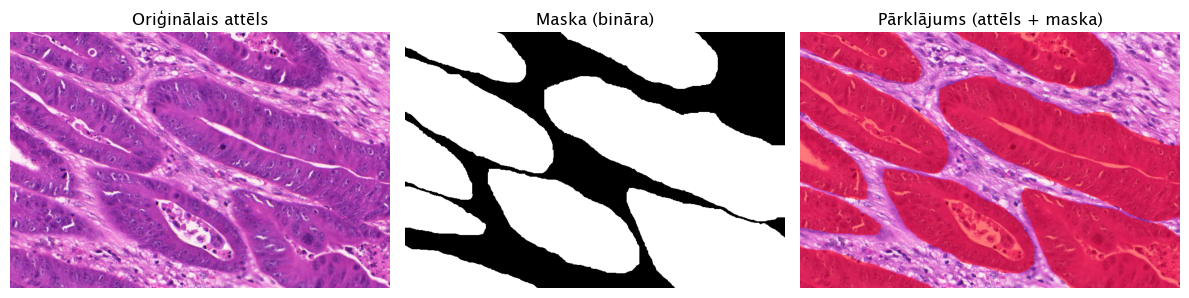

In [9]:
# Vizualizējam attēlu + masku
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Oriģinālais attēls")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Maska (bināra)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Pārklājums (attēls + maska)")
overlay = img_np.copy()
# padarīsim masku sarkanu
red = overlay.copy()
red[..., 0] = 255
red[..., 1] = 0
red[..., 2] = 0

alpha = 0.5
mask_3c = np.stack([mask]*3, axis=-1).astype(bool)
overlay[mask_3c] = (alpha * red[mask_3c] + (1 - alpha) * overlay[mask_3c]).astype(np.uint8)

plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
class GlandSegmentationDataset(Dataset):
    """
    PyTorch Dataset glandu segmentācijai.
    Pieņem datu struktūru:

      root/
        training/
          img/*.bmp
          ann/*.bmp.json
        test/
          img/*.bmp
          ann/*.bmp.json
    """

    def __init__(self, root_dir: Path, split: str = "training", transform: Optional = None):
        assert split in ["training", "test"], "split jābūt 'training' vai 'test'"
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        img_dir = self.root_dir / split / "img"
        ann_dir = self.root_dir / split / "ann"

        self.samples: List[Tuple[Path, Path]] = []

        for img_path in sorted(img_dir.glob("*.bmp")):
            # "12345.bmp" -> "12345.bmp.json"
            ann_path = ann_dir / f"{img_path.name}.json"
            if not ann_path.exists():
                # print(f"[BRĪDINĀJUMS] Trūkst anotācijas priekš {img_path.name}")
                continue
            self.samples.append((img_path, ann_path))

        if not self.samples:
            raise RuntimeError(f"Neatradu nevienu attēla+anotācijas pāri mapē {img_dir}")

        print(f"GlandSegmentationDataset ({split}): {len(self.samples)} paraugi.")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        img_path, ann_path = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img, dtype=np.float32) / 255.0  # (H,W,3)

        mask_np = create_binary_mask_from_json(ann_path).astype(np.float32)  # (H,W)

        if self.transform is not None:
            transformed = self.transform(image=img_np, mask=mask_np)
            img_np = transformed["image"]
            mask_np = transformed["mask"]

        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # (3,H,W)
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)    # (1,H,W)

        return img_tensor, mask_tensor, img_path.name

In [11]:
train_ds = GlandSegmentationDataset(GLAND_ROOT, split="training", transform=None)
test_ds = GlandSegmentationDataset(GLAND_ROOT, split="test", transform=None)

len(train_ds), len(test_ds)

GlandSegmentationDataset (training): 85 paraugi.
GlandSegmentationDataset (test): 80 paraugi.


(85, 80)

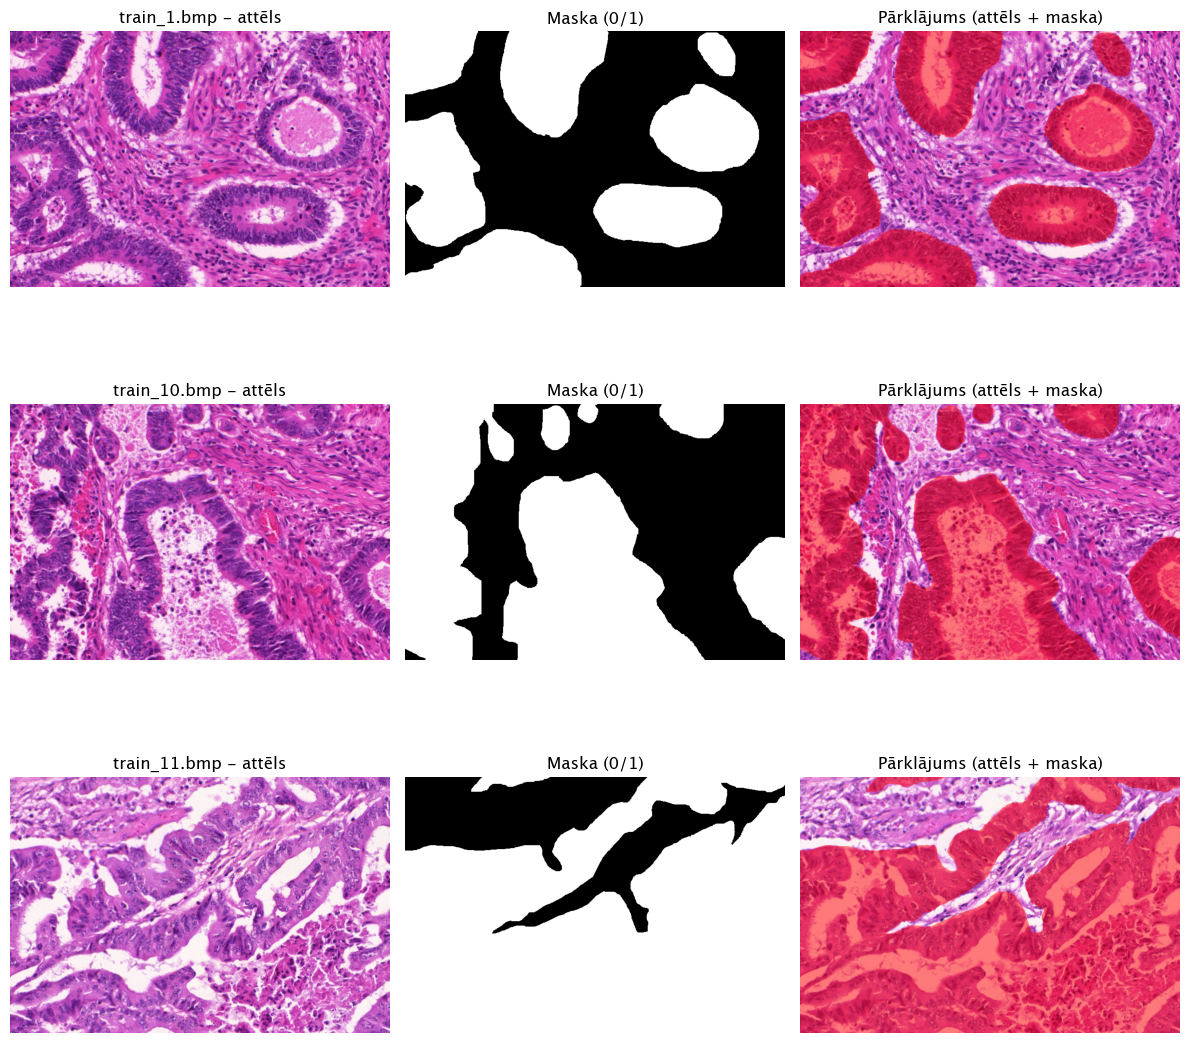

In [12]:
# Paņemam dažus paraugus no treniņa kopas
n_show = 3
fig, axs = plt.subplots(n_show, 3, figsize=(12, 4 * n_show))

for i in range(n_show):
    img_t, mask_t, fname = train_ds[i]
    img_np = img_t.permute(1, 2, 0).numpy()       # (H,W,3)
    mask_np = mask_t.squeeze(0).numpy()           # (H,W)

    axs[i, 0].imshow(img_np)
    axs[i, 0].set_title(f"{fname} - attēls")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(mask_np, cmap="gray")
    axs[i, 1].set_title("Maska (0/1)")
    axs[i, 1].axis("off")

    # overlay
    overlay = img_np.copy()
    red = np.zeros_like(overlay)
    red[..., 0] = 1.0
    alpha = 0.5
    mask3 = np.stack([mask_np]*3, axis=-1).astype(bool)
    overlay[mask3] = alpha * red[mask3] + (1 - alpha) * overlay[mask3]

    axs[i, 2].imshow(overlay)
    axs[i, 2].set_title("Pārklājums (attēls + maska)")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Kopsavilkums

- Datu kopa ir nolasīta no BMP attēliem un JSON anotācijām.
- No anotācijām ģenerējam **bināru masku**: `1 = gland`, `0 = fons`.
- Izveidota `GlandSegmentationDataset` klase, kas atgriež:
  - `img_tensor`: `(3, H, W)`, `float32`, normalizēts [0,1],
  - `mask_tensor`: `(1, H, W)`, `float32`, vērtības 0/1,
  - faila nosaukumu, ko var izmantot debugam.

Nākamais solis – **treniņa notebook**, kurā mēs:

- izveidosim `DataLoader` treniņam un validācijai,
- uztrenēsim `segmentation_models_pytorch.Unet` un `segmentation_models_pytorch.FPN`,
- salīdzināsim to kvalitāti (loss, IoU/Dice, vizuālie rezultāti).